# TensorFlow

In [53]:
import numpy as np

In [54]:
import tensorflow as tf
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2


Najważniejszą rzeczą do zrozumienia jest to, że ten kod w rzeczywistości nie wykonuje żadnych obliczeń, nawet jeśli wygląda na to (szczególnie na ostatniej linii). Po prostu tworzy graf obliczeniowy. 

W rzeczywistości nawet zmienne nie zostały jeszcze zainicjowane. Aby wykonać ten graf, należy otworzyć sesję TensorFlow i użyć jej do zainicjowania zmiennych i wyliczenia $f$. 

Sesja TensorFlow zajmuje się umieszczaniem operacji na urządzeniach takich jak procesory i GPU oraz ich uruchomieniem i przechowuje wszystkie wartości zmiennych:


In [55]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


Ciągłe powtarzanie sesji **sess.run()** jest nieco uciążliwe, ale na szczęście jest lepszy sposób:

In [56]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print(result)

42


Zamiast ręcznie uruchamiać inicjalizator dla każdej zmiennej, można użyć skrótu
Funkcja **global_variables_initializer()**. Zauważ, że nie wykonuje on natychmiastowej nitlizacji, lecz tworzy na wykresie węzeł, który inicjalizuje wszystkie zmienne podczas działania:

In [57]:
init = tf.global_variables_initializer() # prepare an init node
with tf.Session() as sess:
    init.run() # actually initialize all the variables
    result = f.eval()
    print(result)

42


Program TensorFlow dzieli się zazwyczaj na dwie części: pierwsza część tworzy graf obliczeniowy (nazywa się to fazą konstrukcyjną), a druga część uruchamia go (jest to faza wykonania).

# Tworzeniw grfów
Każdy utworzony węzeł jest automatycznie dodawany do domyślnego grafu:

In [58]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

W większości przypadków jest to w porządku, ale czasami możesz chcieć zarządzać wieloma niezależnymi grafami. Możesz to zrobić, tworząc nowy graf i tymczasowo ustawiając go jako domyślny wykres wewnątrz bloku:

In [59]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [60]:
x2.graph is tf.get_default_graph()

False

W Jupyter (lub w powłoce Pythona) często używa się tych samych poleceń więcej niż raz podczas eksperymentowania. W rezultacie może pojawić się domyślny wykres zawierający wiele zduplikowanych węzłów. Jednym z rozwiązań jest ponowne uruchomienie jądra Jupytera (lub powłoki Pythona), ale wygodniejszym rozwiązaniem jest przywrócenie domyślnego wykresu poprzez uruchomienie **tf.reset_default_graph()**.

Podczas inicjalizacji węzła TensorFlow automatycznie określa zestaw węzłów, od których zależy i najpierw inicjalizuje te węzły. Rozważmy na przykład następujący kod:

In [61]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3
with tf.Session() as sess:
    print(y.eval()) 
    print(z.eval()) 

10
15


# Linear Regression with TensorFlow

Weźmy dane housing oraz wykonajmy regresję liniową za pomocą rozwiązania układu równań liniowych.

In [62]:
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
m, n = housing.data.shape
print(m, n)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_data_scaled=scaler.fit_transform(housing.data)

20640 8


Za pomocą NumPy wyglądało by to tak:

In [63]:
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing_data_scaled]
print(housing_data_plus_bias.shape)

(20640, 9)


In [64]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[ 2.06855817]
 [ 0.8296193 ]
 [ 0.11875165]
 [-0.26552688]
 [ 0.30569623]
 [-0.004503  ]
 [-0.03932627]
 [-0.89988565]
 [-0.870541  ]]


Za pomocą Scikit-Learn można to zrobić tak:

In [65]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_data_scaled, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ 2.06855817]
 [ 0.8296193 ]
 [ 0.11875165]
 [-0.26552688]
 [ 0.30569623]
 [-0.004503  ]
 [-0.03932627]
 [-0.89988565]
 [-0.870541  ]]


W tensorflow możemy to zrobić tak

In [66]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

In [67]:
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)

[[ 2.06856298]
 [ 0.82961965]
 [ 0.11875178]
 [-0.26552707]
 [ 0.30569667]
 [-0.00450281]
 [-0.03932635]
 [-0.8998825 ]
 [-0.87053877]]


# Zad.
Wykonaj regresje na poniższych danych oraz narysuj wykres

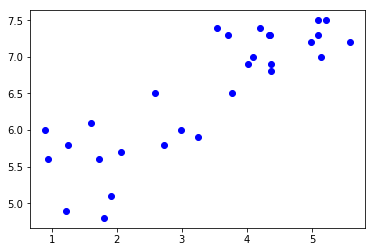

(29, 1)


In [68]:
import numpy as np
import tensorflow as tf
data = np.loadtxt("life_satisfaction.csv",
                  dtype=np.float32,
                  delimiter=",",
                  skiprows=1,
                  usecols=[1, 2])
X_train = data[:, 0:1] / 10000 # feature scaling
y_train = data[:, 1:2]

import matplotlib.pyplot as plt

plt.plot(X_train, y_train, "bo")
plt.show()
print(X_train.shape)

In [82]:
data_plus_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
data_plus_bias_m, data_plus_bias_n = data_plus_bias.shape
print(data_m, data_n)

X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32, name="y")

XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)
    

29 2
[[ 4.85305166]
 [ 0.49115562]]


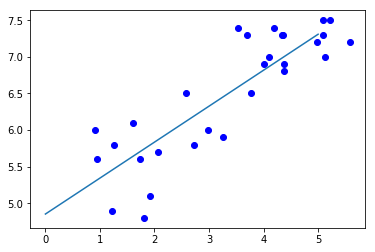

In [83]:
plt.plot(X_train, y_train, "bo")
#plt.plot([0, 60000], [theta_value[1][0], w[0][0] * (60000 / 10000) + theta_value[1][0]])
plt.plot([0, 5], [theta_value[0][0],theta_value[1][0]*5+theta_value[0][0]])
plt.show()

# Implementing Gradient Descent
Możemy zminimalizować funkcję kosztu gradientowo wykorzystując gradient:
```python
gradients = 2/m * tf.matmul(tf.transpose(X), error)
```

In [84]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
[[  2.06855226e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845096e-01]
 [  1.64778158e-01]
 [  7.44080753e-04]
 [ -3.91945168e-02]
 [ -8.61356616e-01]
 [ -8.23479712e-01]]


# Zad.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

In [89]:
tf.reset_default_graph()



2
Epoch 0 MSE = 19.6125
Epoch 100 MSE = 1.35452
Epoch 200 MSE = 0.83155
Epoch 300 MSE = 0.541586
Epoch 400 MSE = 0.380816
Epoch 500 MSE = 0.291677
Epoch 600 MSE = 0.242254
Epoch 700 MSE = 0.214851
Epoch 800 MSE = 0.199657
Epoch 900 MSE = 0.191233
[[ 4.66054201]
 [ 0.54031867]]


Możemy też użyć gradientu wyliczonego za pomocą automatycznego różniczkowania
```python
gradients = tf.gradients(mse, [theta])[0]
```

In [91]:
tf.reset_default_graph()



Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


# Zad.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

In [92]:
tf.reset_default_graph()


2
Epoch 0 MSE = 19.6125
Epoch 100 MSE = 1.35452
Epoch 200 MSE = 0.83155
Epoch 300 MSE = 0.541586
Epoch 400 MSE = 0.380816
Epoch 500 MSE = 0.291677
Epoch 600 MSE = 0.242254
Epoch 700 MSE = 0.214851
Epoch 800 MSE = 0.199657
Epoch 900 MSE = 0.191233
[[ 4.66054201]
 [ 0.54031867]]


## Ciekwaostka

Jak można znaleźć pochodne cząstkowe poniższej funkcji w odniesieniu do a i b?

In [23]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

my_func(0.2, 0.3)

-0.21253923284754914

In [24]:
tf.reset_default_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.212537
[-1.1388494, 0.19671395]


## Gradient Descent Optimizer

Możemy również użyć wbudowanej funkcji do optymalizacji

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
```

In [93]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)


init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


Jest wiele różnych metod optymalizacji

In [95]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")


optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.527316
Epoch 200 MSE = 0.524414
Epoch 300 MSE = 0.524328
Epoch 400 MSE = 0.524322
Epoch 500 MSE = 0.524321
Epoch 600 MSE = 0.524321
Epoch 700 MSE = 0.52432
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321
Best theta:
[[ 2.06855798]
 [ 0.82961673]
 [ 0.11875112]
 [-0.26552212]
 [ 0.30569226]
 [-0.00450316]
 [-0.03932616]
 [-0.89989167]
 [-0.87054664]]


# Zad.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

In [98]:
tf.reset_default_graph()



Epoch 0 MSE = 19.6125
Epoch 100 MSE = 0.181109
Epoch 200 MSE = 0.18075
Epoch 300 MSE = 0.18075
Epoch 400 MSE = 0.18075
Epoch 500 MSE = 0.18075
Epoch 600 MSE = 0.18075
Epoch 700 MSE = 0.18075
Epoch 800 MSE = 0.18075
Epoch 900 MSE = 0.18075
Best theta:
[[ 4.853055 ]
 [ 0.4911539]]


# Warstwa typu placeholder
Warstwa typu placeholder pozwala na dynamiczne dostarczanie danych

In [99]:
tf.reset_default_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)
print(B_val_2)

[[ 6.  7.  8.]]
[[  9.  10.  11.]
 [ 12.  13.  14.]]


W naszym przypadku mamy:

In [100]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [111]:
n_epochs = 100
batch_size = 100
n_batches = int(np.ceil(m / batch_size))


def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            print("Epoch", epoch, "MSE =", sess.run( mse, feed_dict={X: X_batch, y: y_batch}) )   

    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")
    
print("Best theta:")
print(best_theta)    

Epoch 0 MSE = 0.502484
Epoch 10 MSE = 0.561448
Epoch 20 MSE = 0.552032
Epoch 30 MSE = 0.590603
Epoch 40 MSE = 0.344873
Epoch 50 MSE = 0.440544
Epoch 60 MSE = 0.548122
Epoch 70 MSE = 0.448121
Epoch 80 MSE = 0.585612
Epoch 90 MSE = 0.386596
Best theta:
[[ 2.0544672 ]
 [ 0.82970113]
 [ 0.10713524]
 [-0.31074819]
 [ 0.24564511]
 [-0.00222412]
 [-0.01061389]
 [-0.89121586]
 [-0.87524796]]


In [112]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() 

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [113]:
print(best_theta_restored)

[[ 2.0544672 ]
 [ 0.82970113]
 [ 0.10713524]
 [-0.31074819]
 [ 0.24564511]
 [-0.00222412]
 [-0.01061389]
 [-0.89121586]
 [-0.87524796]]


# Zad.
Proszę wykonać regresję za pomocą sieci neuronowej złożonej z dwóch warstw fully connected z warstwą aktywacji relu na poniższych danych.

In [ ]:
true_fun = lambda X: np.cos(1.5 * np.pi * X)
n_samples=200
X_train = np.sort(np.random.rand(n_samples))
y_train = true_fun(X_train) + np.random.randn(n_samples) * 0.1
X_train=np.vstack(X_train)
y_train=np.vstack(y_train)
import matplotlib.pyplot as plt

plt.plot(X_train, y_train, "bo")
plt.show()

In [115]:
tf.reset_default_graph()

n_inputs = 1
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 1

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")

Wykorzystamy sieć typu fully_connected z funkcją aktywacji relu.

In [116]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

In [117]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
    y_pred = neuron_layer(hidden2, n_outputs, "outputs")
    
with tf.name_scope("loss"):
    error = y_pred - y
    loss = tf.reduce_mean(tf.square(error), name="mse")
        
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    
    

In [123]:
x_dom = np.vstack(np.arange(0,1,0.01))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 4000
batch_size = 50
n_batches = int(np.ceil(len(X_train) / batch_size))

def fetch_batch(epoch, batch_index, batch_size, X,  y):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(X.shape[0], size=batch_size)  # not shown
    X_batch = X[indices] # not shown
    y_batch = y[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size, X_train, y_train)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            acc_train = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print("Epoch", epoch, "mse:", acc_train)#, "Val accuracy:", acc_val)
    x_dom_pred = y_pred.eval(feed_dict={X: x_dom})
    #save_path = saver.save(sess, "./my_model_final.ckpt")

Epoch 0 mse: 0.23533
Epoch 100 mse: 0.182371
Epoch 200 mse: 0.195548
Epoch 300 mse: 0.119697
Epoch 400 mse: 0.148003
Epoch 500 mse: 0.100984
Epoch 600 mse: 0.131563
Epoch 700 mse: 0.0646537
Epoch 800 mse: 0.0647853
Epoch 900 mse: 0.0867684
Epoch 1000 mse: 0.0649976
Epoch 1100 mse: 0.0633444
Epoch 1200 mse: 0.0416062
Epoch 1300 mse: 0.0299712
Epoch 1400 mse: 0.0370246
Epoch 1500 mse: 0.0337202
Epoch 1600 mse: 0.0139638
Epoch 1700 mse: 0.0168709
Epoch 1800 mse: 0.0155166
Epoch 1900 mse: 0.0155002
Epoch 2000 mse: 0.0254837
Epoch 2100 mse: 0.00921041
Epoch 2200 mse: 0.0141502
Epoch 2300 mse: 0.0154058
Epoch 2400 mse: 0.0117753
Epoch 2500 mse: 0.0097913
Epoch 2600 mse: 0.0141501
Epoch 2700 mse: 0.0120437
Epoch 2800 mse: 0.00835322
Epoch 2900 mse: 0.00738988
Epoch 3000 mse: 0.0133471
Epoch 3100 mse: 0.0155926
Epoch 3200 mse: 0.0101292
Epoch 3300 mse: 0.012084
Epoch 3400 mse: 0.01009
Epoch 3500 mse: 0.0128957
Epoch 3600 mse: 0.0118116
Epoch 3700 mse: 0.0130931
Epoch 3800 mse: 0.00851442
Epoch

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_train, y_train, "bo")
plt.plot(x_dom, x_dom_pred, color='red',linewidth=3)
plt.show()

# Zad.
Proszę wykonać regresję za pomocą sieci neuronowej złożonej z dwóch warstw fully connected z warstwą aktywacji relu na danych 
housing .